In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from gbor.main import BoostedOrdinal
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import cross_val_score, RepeatedKFold

wine_red = pd.read_csv('../data/winequality-red.csv', sep = ';')
#wine_red = pd.read_csv('../data/winequality-white.csv', sep = ';')
wine_red['quality'] = wine_red['quality'] - np.min(wine_red['quality'])

#wine_red_filtered = wine_red[(wine_red['quality'] != 5) & (wine_red['quality'] != 0)]
#wine_red_filtered = wine_red[(wine_red['quality'] != 0)]
wine_red_filtered = wine_red

X, y = wine_red_filtered.drop(columns = ['quality']).to_numpy(), wine_red_filtered['quality'].to_numpy(dtype = 'int')
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 10,  53, 681, 638, 199,  18], dtype=int64))

In [8]:
gbor = BoostedOrdinal(
    n_iter_no_change = 100
    , max_iter = 10
    , base_learner = DecisionTreeRegressor(max_depth = 6)
    , lr_g = 1e-1
    , lr_theta = 1#e-4
    , validation_stratify = False
    , validation_fraction = 0.2
    , reltol = 0.0
    , n_class = 6
    , cv = 5
)

In [9]:
my_random_state = 1
cv = RepeatedKFold(n_repeats = 5, n_splits = 2, random_state = my_random_state)

start_time = time.time()
my_cv = cross_val_score(
    gbor, X, y, cv = cv
    , scoring = 'accuracy'
    , n_jobs = 10
)
end_time = time.time()
print('time: {} sec'.format(round(end_time - start_time, 1)))

time: 8.1 sec


In [10]:
my_cv

array([0.57875   , 0.58197747, 0.5775    , 0.6020025 , 0.615     ,
       0.55694618, 0.58125   , 0.57196496, 0.6025    , 0.58948686])

In [11]:
parameter_grid = {'base_learner__max_depth': [3, 6, 9], 'lr_g': [1e0, 1e-1, 1e-2]}
new_gridsearch = GridSearchCV(
    gbor
    , parameter_grid
    , scoring = 'accuracy'
    , n_jobs = 1
)
start_time = time.time()
my_cv2 = cross_val_score(
    new_gridsearch, X, y, cv = cv
    , scoring = 'accuracy'
    , n_jobs = 10
    , verbose = 2
)
end_time = time.time()
print('time: {} sec'.format(round(end_time - start_time, 1)))


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  5.2min remaining: 12.1min


time: 313.6 sec


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  5.2min finished


In [12]:
my_cv2

array([0.57125   , 0.57071339, 0.55875   , 0.57446809, 0.6125    ,
       0.57697121, 0.59375   , 0.59949937, 0.56875   , 0.5844806 ])

In [13]:
from scipy.stats import pearsonr

# Perform Pearson correlation test
corr_coef, p_value = pearsonr(my_cv, my_cv2)

print(f"Pearson correlation coefficient: {corr_coef}")
print(f"P-value: {p_value}")


Pearson correlation coefficient: 0.2871328582062903
P-value: 0.4211696792806291


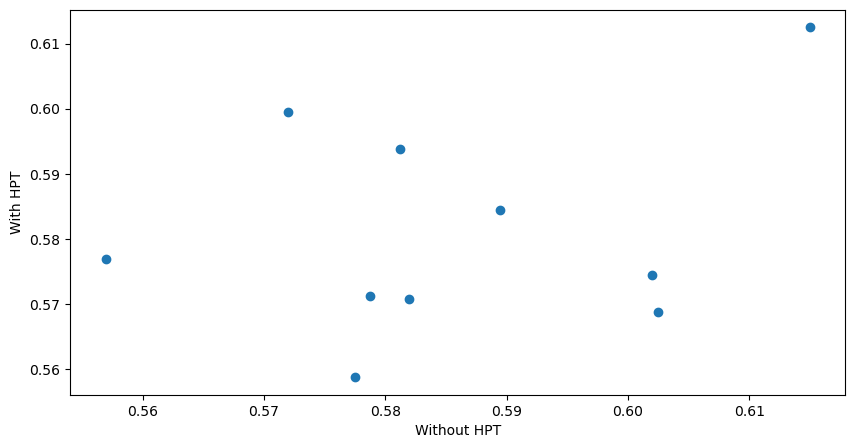

In [14]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 5))

# Plot the first array
plt.plot(my_cv, my_cv2, linestyle = "", marker='o')

# Plot the second array
#plt.plot(np.arange(10), cross_entropy_validation, label='Validation set')#, marker='x')

# Add labels and title
plt.xlabel('Without HPT')
plt.ylabel('With HPT')
#plt.title('Training vs. Validation Cross-entropy Loss')

#plt.legend()

# Show the plot
plt.show()
